In [44]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load training data
train_df = pd.read_csv("../training_data.csv")

# Load testing data
test_df = pd.read_csv("../target.csv")

# Preprocess training data
train_texts = train_df['cleaned'].tolist()
train_titles = train_df['filename'].tolist()
train_labels_narrative = train_df['narrative'].apply(lambda x: x.split(';')).tolist()
train_labels_subnarrative = train_df['sub_narrative'].apply(lambda x: x.split(';')).tolist()
train_languages = train_df['language'].tolist()

# Preprocess testing data
test_texts = test_df['cleaned'].tolist()
test_titles = test_df['filename'].tolist()
test_labels_narrative = test_df['narrative'].apply(lambda x: x.split(';')).tolist()
test_labels_subnarrative = test_df['sub_narrative'].apply(lambda x: x.split(';')).tolist()
test_languages = test_df['language'].tolist()

# Vectorize texts
vectorizer = CountVectorizer(max_df=0.75, min_df=1, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Binarize labels
mlb_narrative = MultiLabelBinarizer()
y_train_narrative = mlb_narrative.fit_transform(train_labels_narrative)
y_test_narrative = mlb_narrative.transform(test_labels_narrative)

mlb_subnarrative = MultiLabelBinarizer()
y_train_subnarrative = mlb_subnarrative.fit_transform(train_labels_subnarrative)
y_test_subnarrative = mlb_subnarrative.transform(test_labels_subnarrative)

# Encode languages
le = LabelEncoder()
y_train_lang = le.fit_transform(train_languages)
y_test_lang = le.transform(test_languages)

# Train Naive Bayes classifier for language
nb_lang = MultinomialNB(alpha=1.25, fit_prior=True)
nb_lang.fit(X_train, y_train_lang)

# Train Naive Bayes classifier for narrative labels
nb_narrative = OneVsRestClassifier(MultinomialNB(alpha=1, fit_prior=True))
nb_narrative.fit(X_train, y_train_narrative)

# Train Naive Bayes classifier for subnarrative labels
nb_subnarrative = OneVsRestClassifier(MultinomialNB(alpha=1.25, fit_prior=True))
nb_subnarrative.fit(X_train, y_train_subnarrative)

# Predict on testing data
pred_lang = nb_lang.predict(X_test)
pred_narrative = nb_narrative.predict(X_test)
pred_subnarrative = nb_subnarrative.predict(X_test)

# Convert predictions back to label format
pred_labels_lang = le.inverse_transform(pred_lang)
pred_labels_narrative = mlb_narrative.inverse_transform(pred_narrative)
pred_labels_subnarrative = mlb_subnarrative.inverse_transform(pred_subnarrative)

# Create a DataFrame with filenames and predicted labels
output_df = pd.DataFrame({
    'Filename': test_titles,
    'Predicted Language': pred_labels_lang,
    'Predicted Narrative': [';'.join(labels) for labels in pred_labels_narrative],
    'Predicted Subnarrative': [';'.join(labels) for labels in pred_labels_subnarrative]
})

# Save the DataFrame to a CSV file
output_df.to_csv('predicted_labels.csv', index=False)

print("Predicted labels saved to 'predicted_labels.csv'")

c:\Users\elfir\anaconda3\envs\nlp\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['CC: Green policies are geopolitical instruments: Other'] will be ignored
  warnings.warn(


Predicted labels saved to 'predicted_labels.csv'


Language Classification Report:
              precision    recall  f1-score   support

          EN       1.00      1.00      1.00        41
          PT       1.00      1.00      1.00        35

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76

Narrative Classification Report:
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.88      1.00      0.94        23
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.50      0.50      0.50         2
                     CC: Criticism of climate movement       0.83      0.62      0.71         8
                     CC: Criticism of climate policies       0.50      0.25      0.33        12
         CC: Criticism of insti

c:\Users\elfir\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elfir\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elfir\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elfir

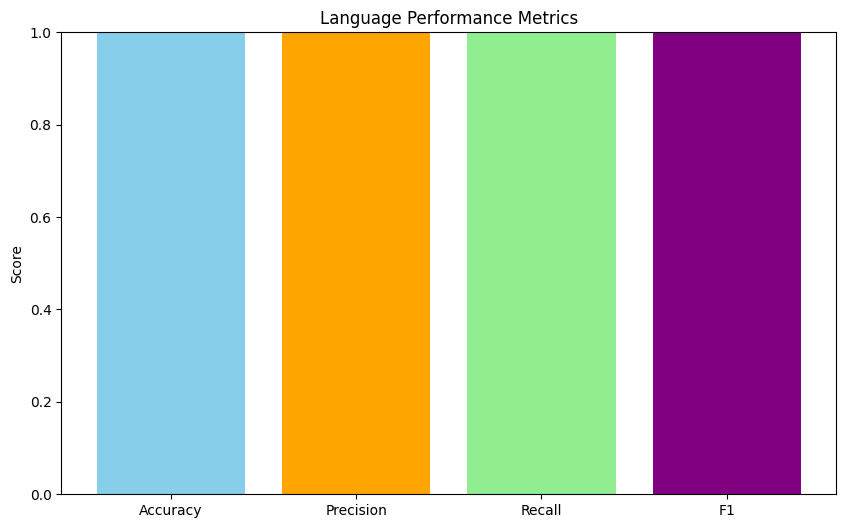

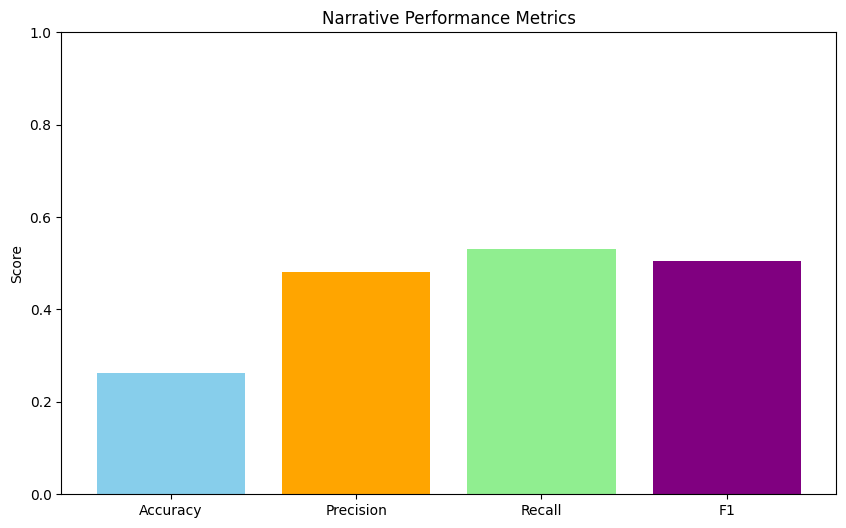

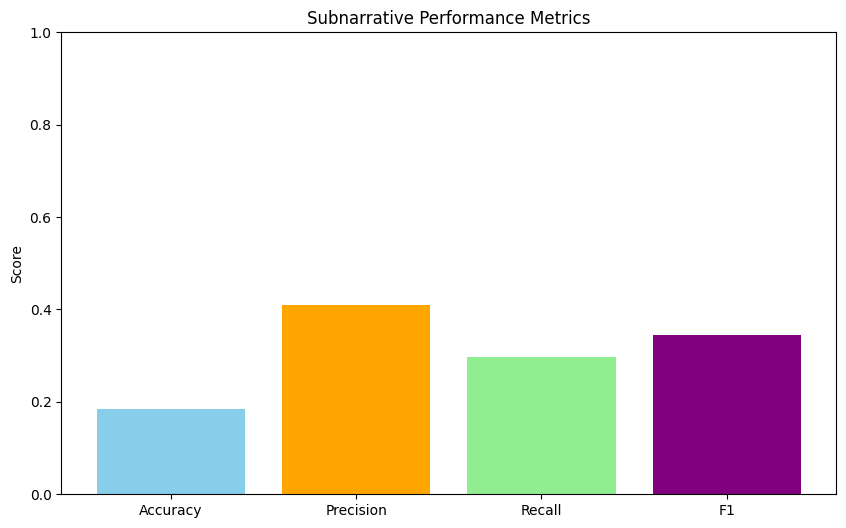

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model
print("Language Classification Report:")
print(classification_report(y_test_lang, pred_lang, target_names=le.classes_))

print("Narrative Classification Report:")
print(classification_report(y_test_narrative, pred_narrative, target_names=mlb_narrative.classes_))

print("Subnarrative Classification Report:")
print(classification_report(y_test_subnarrative, pred_subnarrative, target_names=mlb_subnarrative.classes_))

def calculate_metrics(y_true, y_pred, average_method="micro"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average_method, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average_method, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average_method, zero_division=0)
    return accuracy, precision, recall, f1

def plot_metrics_comparison(language_metrics, narrative_metrics, subnarrative_metrics):
    categories = ['Accuracy', 'Precision', 'Recall', 'F1']
    x = range(len(categories))

    data = {
        'Language': language_metrics,
        'Narrative': narrative_metrics,
        'Subnarrative': subnarrative_metrics
    }

    for key, metrics in data.items():
        plt.figure(figsize=(10, 6))
        plt.bar(x, metrics, color=['skyblue', 'orange', 'lightgreen', 'purple'])
        plt.xticks(x, categories)
        plt.ylim(0, 1)
        plt.title(f'{key} Performance Metrics')
        plt.ylabel('Score')
        plt.show()

# Calculate metrics for each task
lang_metrics = calculate_metrics(y_test_lang, pred_lang, average_method="macro")
narrative_metrics = calculate_metrics(y_test_narrative, pred_narrative, average_method="micro")
subnarrative_metrics = calculate_metrics(y_test_subnarrative, pred_subnarrative, average_method="micro")

# Print metrics
print(f"Language Metrics (Accuracy, Precision, Recall, F1): {lang_metrics}")
print(f"Narrative Metrics (Accuracy, Precision, Recall, F1): {narrative_metrics}")
print(f"Subnarrative Metrics (Accuracy, Precision, Recall, F1): {subnarrative_metrics}")

# Plot metrics comparison
plot_metrics_comparison(lang_metrics, narrative_metrics, subnarrative_metrics)

# # Confusion matrix for language classification
# cm_lang = confusion_matrix(y_test_lang, pred_lang)
# sns.heatmap(cm_lang, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Language Classification')
# plt.show()

# # Confusion matrix for narrative classification
# cm_narrative = confusion_matrix(y_test_narrative.argmax(axis=1), pred_narrative.argmax(axis=1))
# sns.heatmap(cm_narrative, annot=True, fmt='d', cmap='Blues', xticklabels=mlb_narrative.classes_, yticklabels=mlb_narrative.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Narrative Classification')
# plt.show()

# # Confusion matrix for subnarrative classification
# cm_subnarrative = confusion_matrix(y_test_subnarrative.argmax(axis=1), pred_subnarrative.argmax(axis=1))
# sns.heatmap(cm_subnarrative, annot=True, fmt='d', cmap='Blues', xticklabels=mlb_subnarrative.classes_, yticklabels=mlb_subnarrative.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix for Subnarrative Classification')
# plt.show()

c:\Users\elfir\anaconda3\envs\nlp\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['CC: Green policies are geopolitical instruments: Other'] will be ignored
  warnings.warn(
C:\Users\elfir\AppData\Local\Temp\ipykernel_17692\1643404039.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Task': 'Language', 'Alpha': alpha, 'Accuracy': lang_metrics[0], 'Precision': lang_metrics[1], 'Recall': lang_metrics[2], 'F1': lang_metrics[3], 'F1 Macro': lang_metrics[4], 'F1 Micro': lang_metrics[5], 'F1 Std Dev': lang_metrics[6]}])], ignore_index=True)
c:\Users\elfir\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-sco

            Task  Alpha  Accuracy  Precision    Recall        F1  F1 Macro  \
0       Language   0.10  1.000000   1.000000  1.000000  1.000000  1.000000   
1      Narrative   0.10  0.223684   0.414286  0.591837  0.487395  0.313601   
2   Subnarrative   0.10  0.078947   0.263473  0.458333  0.334601  0.118911   
3       Language   0.50  1.000000   1.000000  1.000000  1.000000  1.000000   
4      Narrative   0.50  0.197368   0.422111  0.571429  0.485549  0.288314   
5   Subnarrative   0.50  0.105263   0.316456  0.390625  0.349650  0.088620   
6       Language   0.75  1.000000   1.000000  1.000000  1.000000  1.000000   
7      Narrative   0.75  0.223684   0.460674  0.557823  0.504615  0.298067   
8   Subnarrative   0.75  0.157895   0.352941  0.343750  0.348285  0.072216   
9       Language   1.00  1.000000   1.000000  1.000000  1.000000  1.000000   
10     Narrative   1.00  0.263158   0.481481  0.530612  0.504854  0.296468   
11  Subnarrative   1.00  0.157895   0.385093  0.322917  0.351275

c:\Users\elfir\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elfir\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


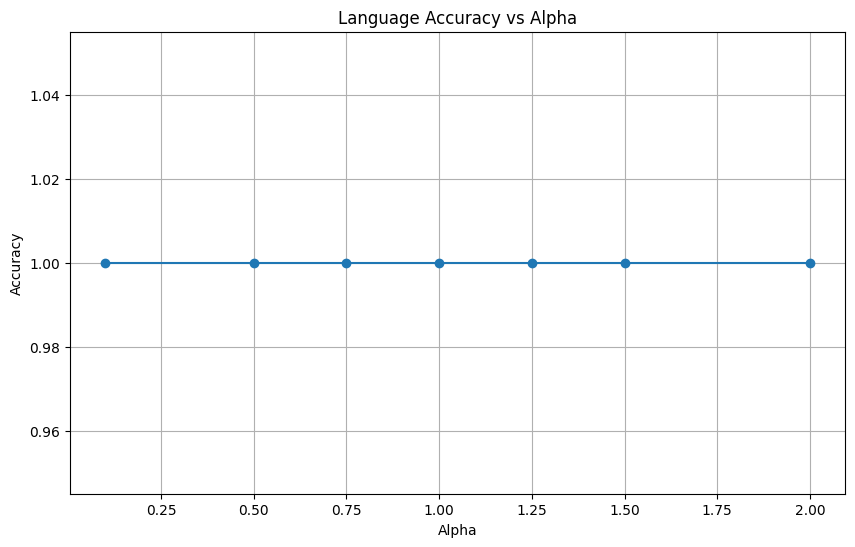

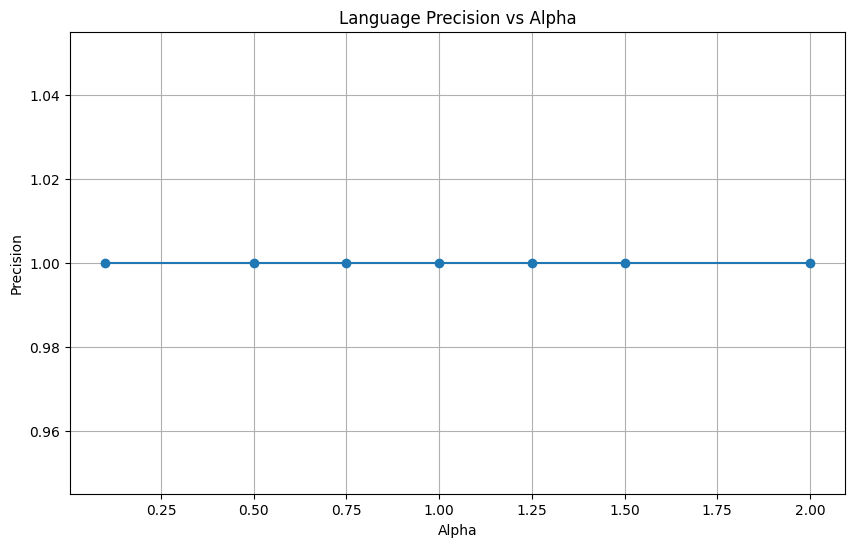

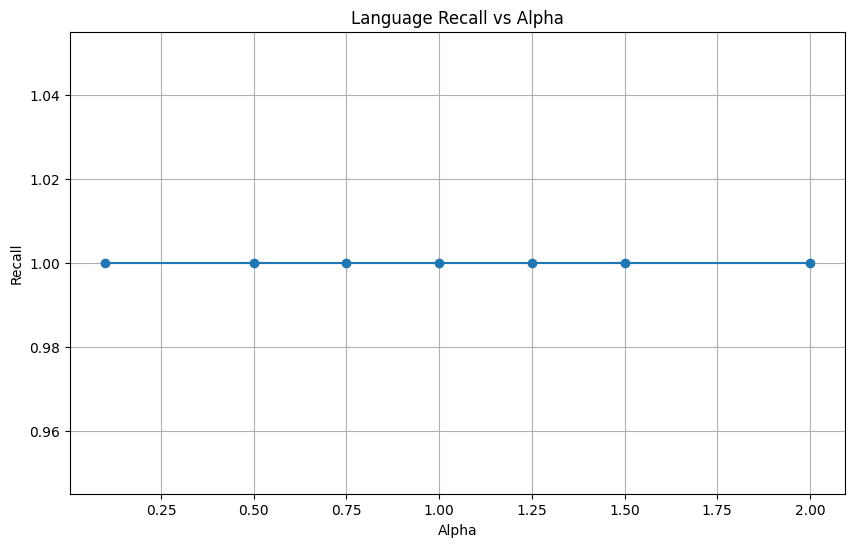

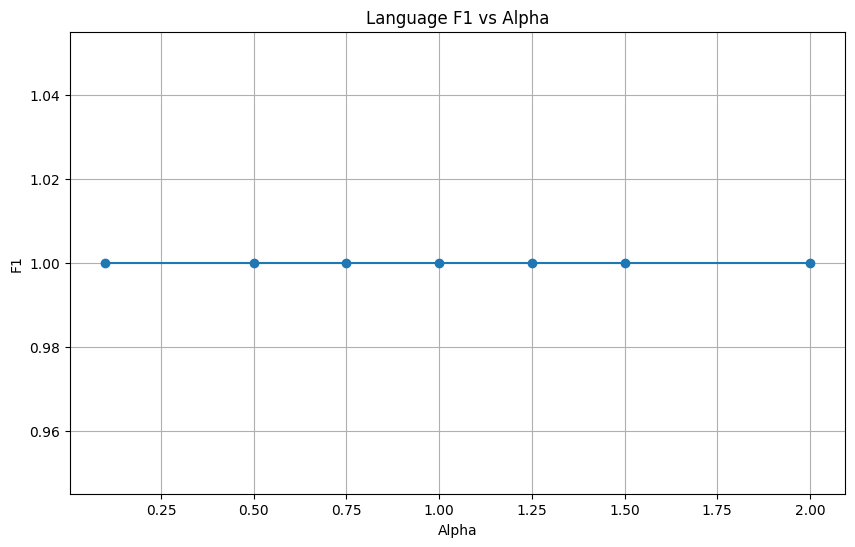

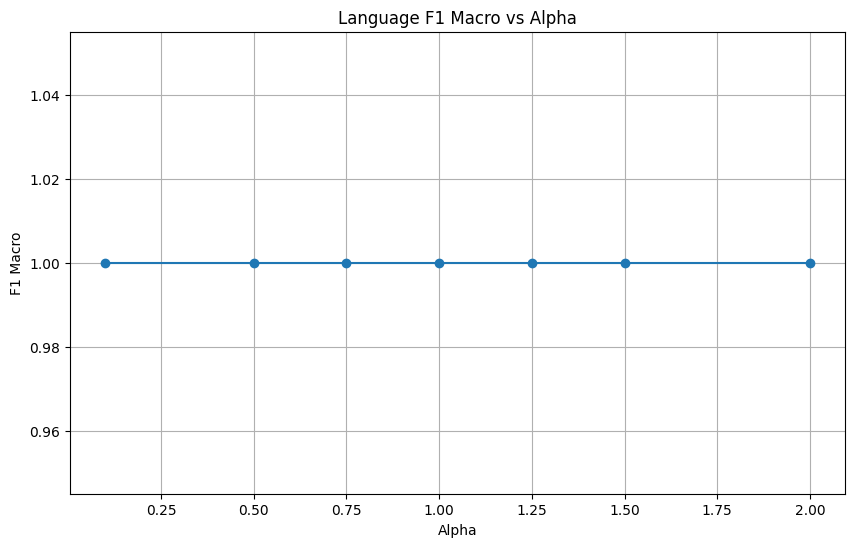

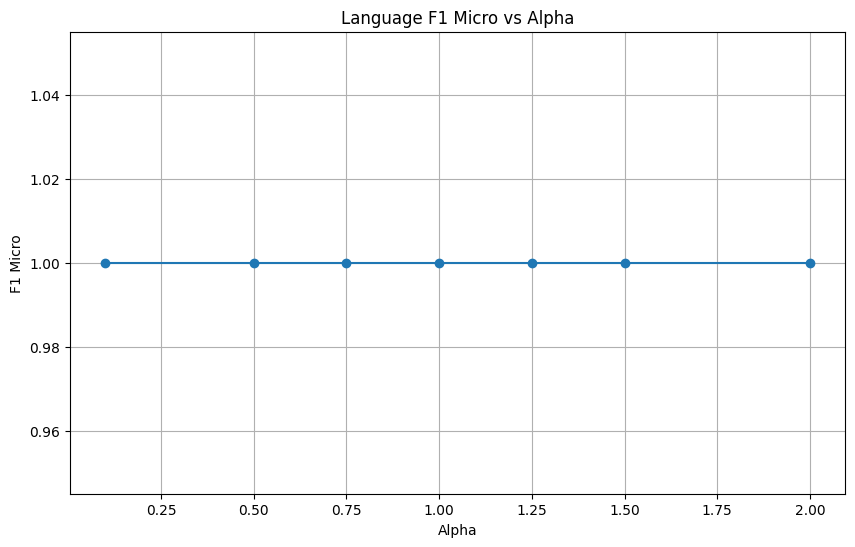

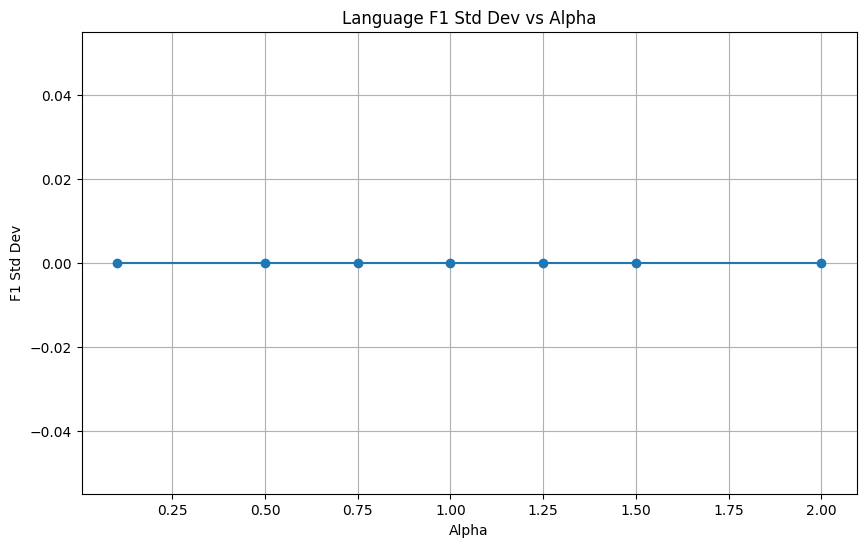

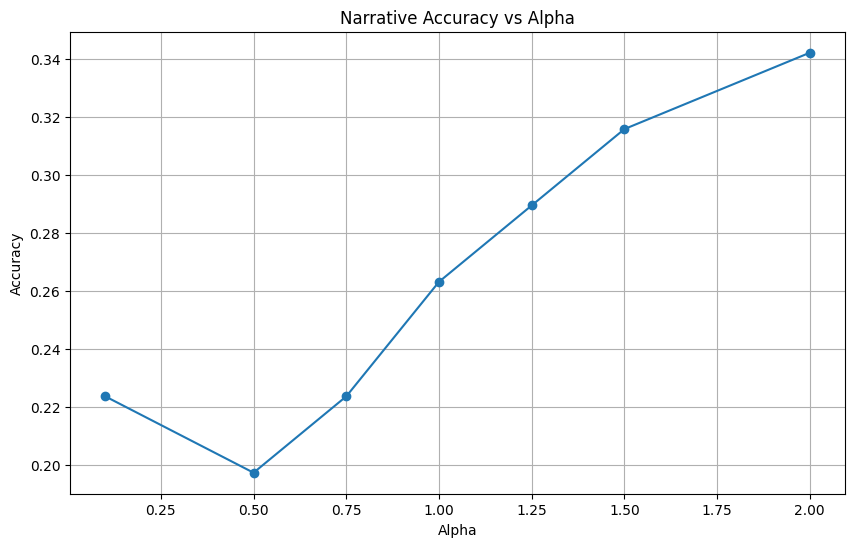

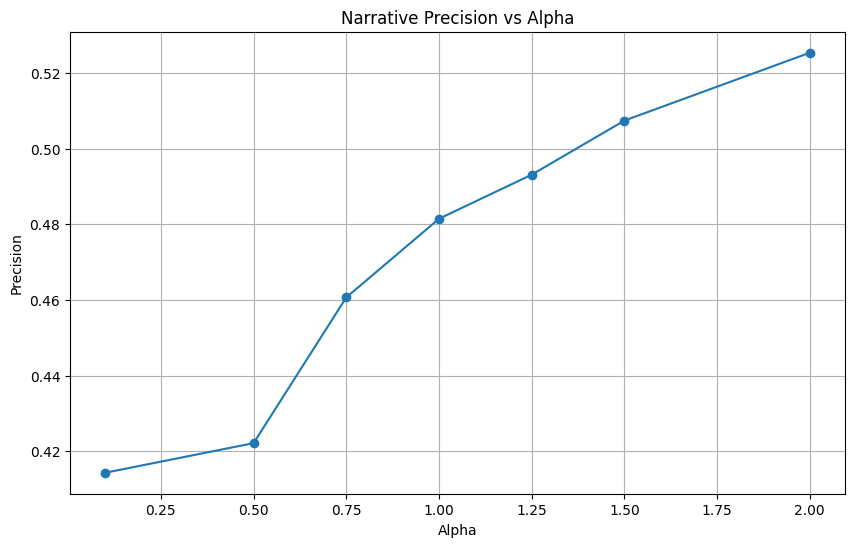

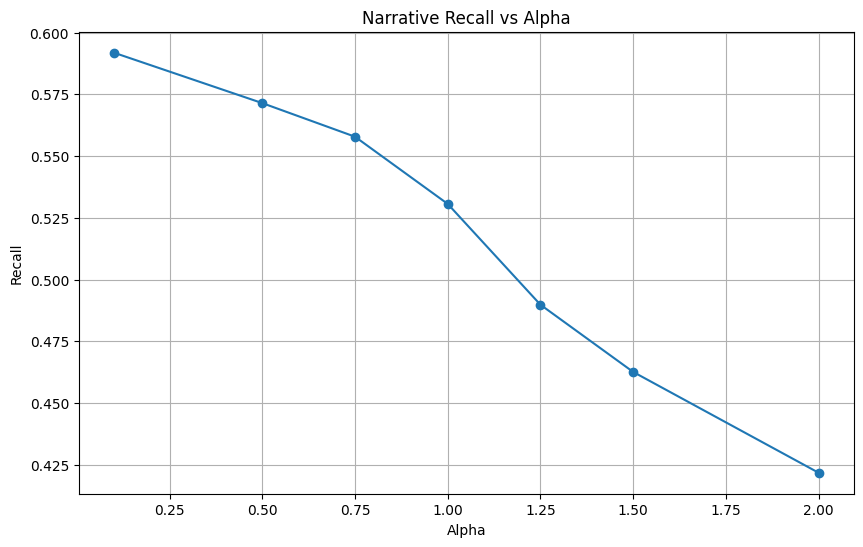

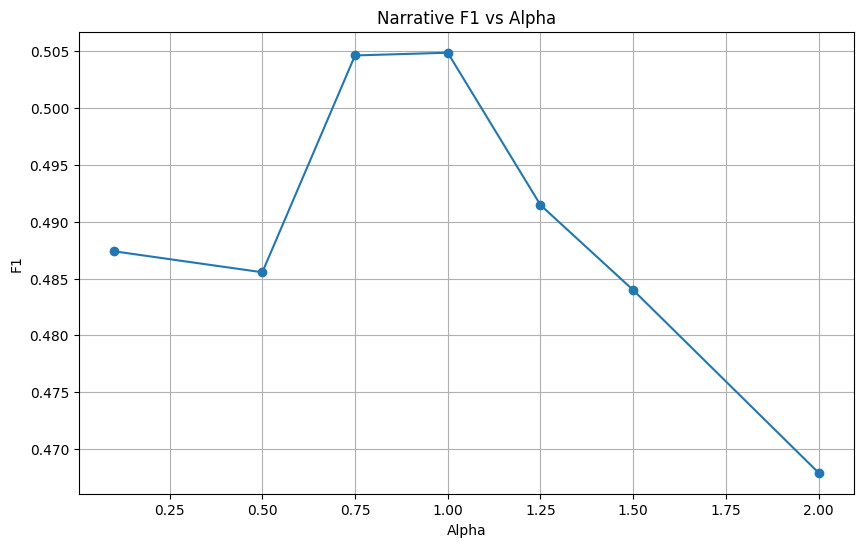

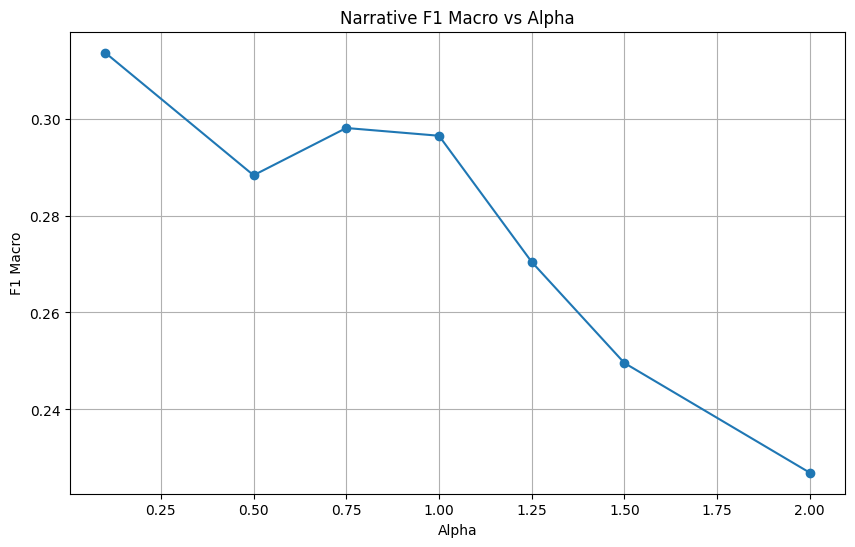

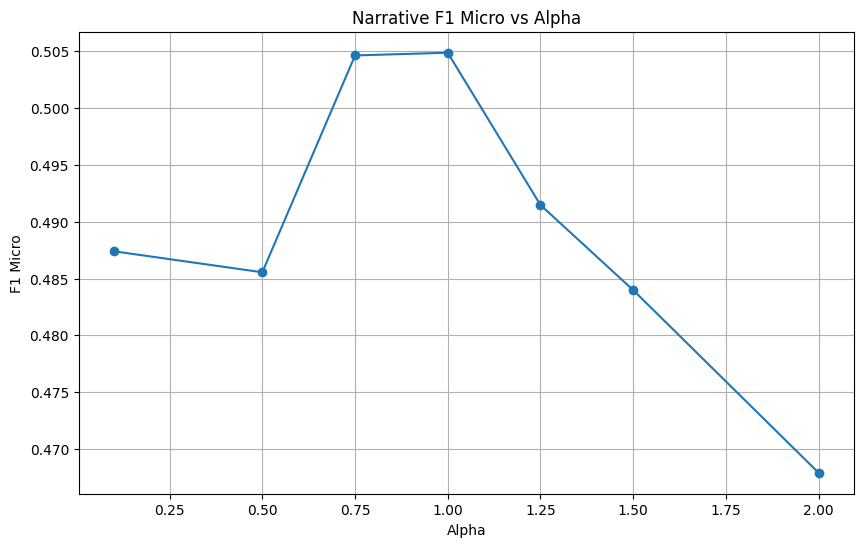

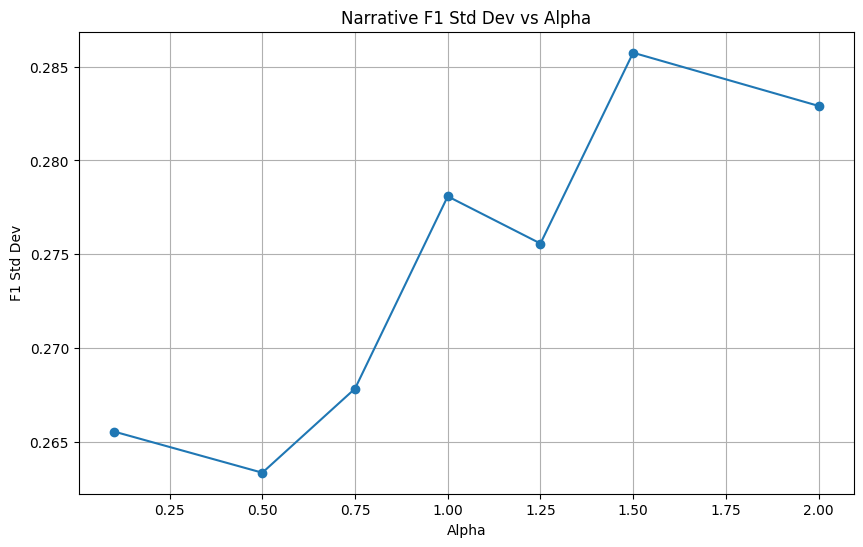

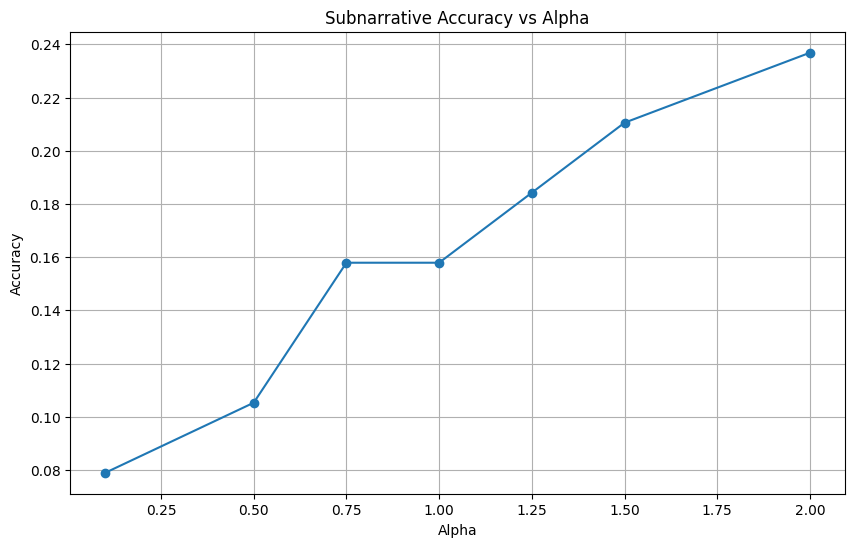

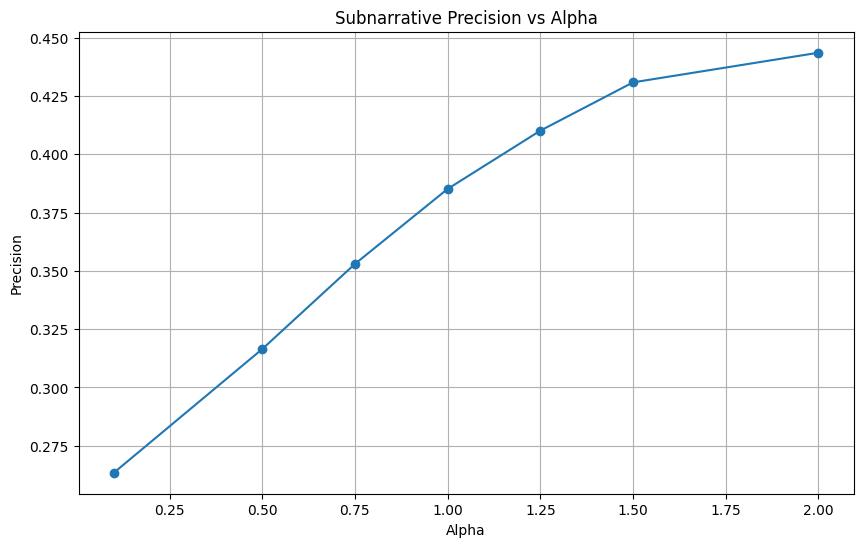

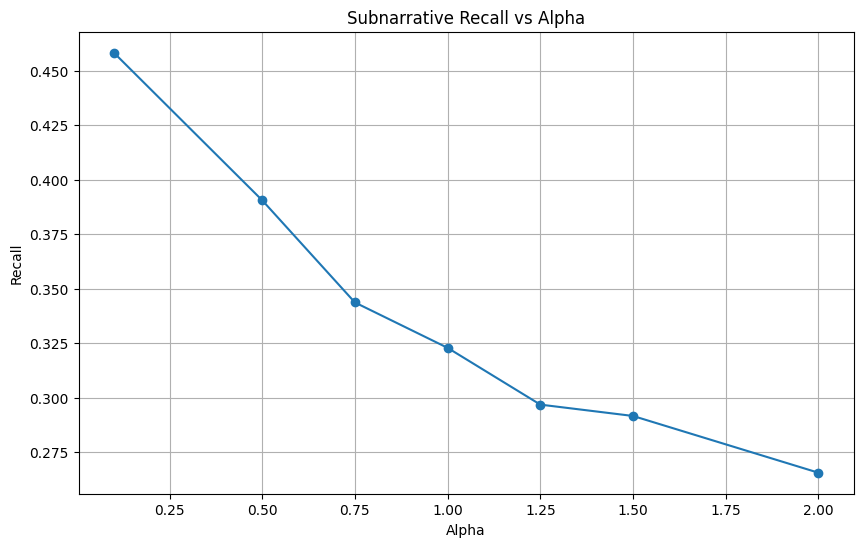

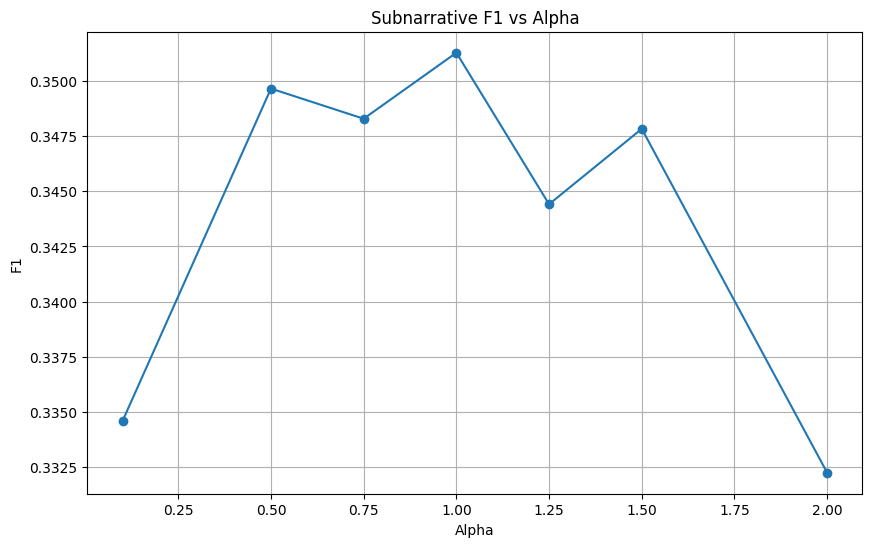

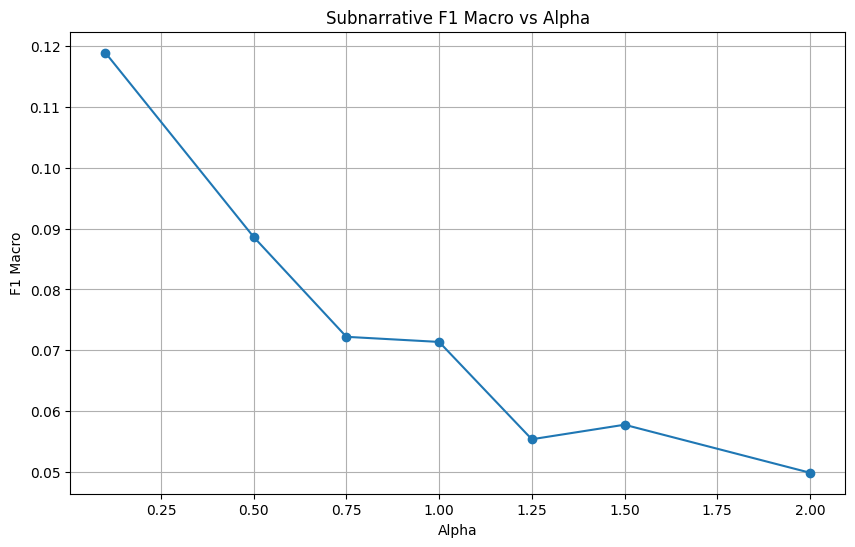

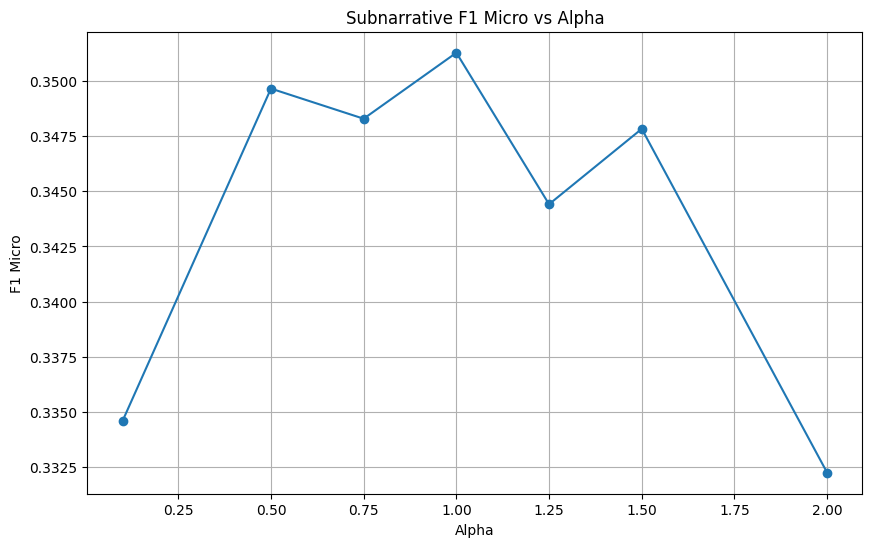

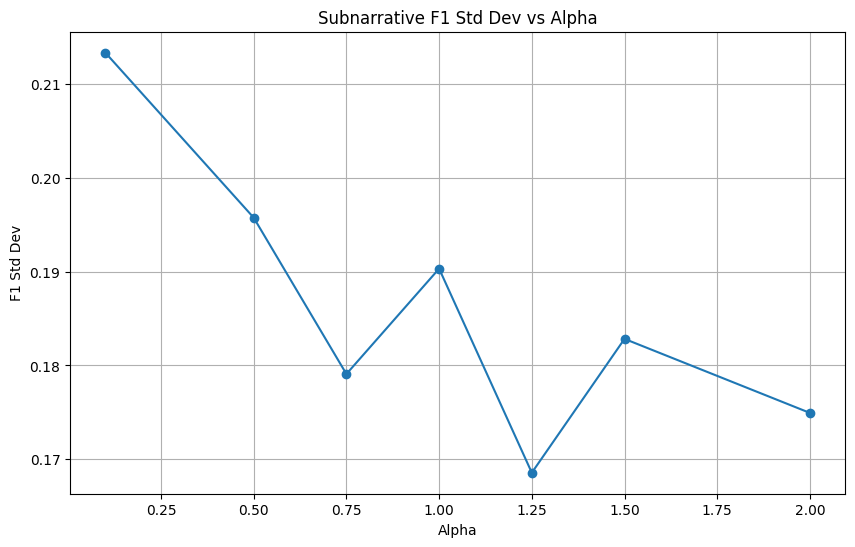

In [43]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Load training data
train_df = pd.read_csv("../training_data.csv")

# Load testing data
test_df = pd.read_csv("../target.csv")

# Preprocess training data
train_texts = train_df['cleaned'].tolist()
train_titles = train_df['filename'].tolist()
train_labels_narrative = train_df['narrative'].apply(lambda x: x.split(';')).tolist()
train_labels_subnarrative = train_df['sub_narrative'].apply(lambda x: x.split(';')).tolist()
train_languages = train_df['language'].tolist()

# Preprocess testing data
test_texts = test_df['cleaned'].tolist()
test_titles = test_df['filename'].tolist()
test_labels_narrative = test_df['narrative'].apply(lambda x: x.split(';')).tolist()
test_labels_subnarrative = test_df['sub_narrative'].apply(lambda x: x.split(';')).tolist()
test_languages = test_df['language'].tolist()

# Vectorize texts
vectorizer = CountVectorizer(max_df=0.75, min_df=1, ngram_range=(1,1))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Binarize labels
mlb_narrative = MultiLabelBinarizer()
y_train_narrative = mlb_narrative.fit_transform(train_labels_narrative)
y_test_narrative = mlb_narrative.transform(test_labels_narrative)

mlb_subnarrative = MultiLabelBinarizer()
y_train_subnarrative = mlb_subnarrative.fit_transform(train_labels_subnarrative)
y_test_subnarrative = mlb_subnarrative.transform(test_labels_subnarrative)

# Encode languages
le = LabelEncoder()
y_train_lang = le.fit_transform(train_languages)
y_test_lang = le.transform(test_languages)

# Define alpha values to test
alpha_values = [0.1, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Task', 'Alpha', 'Accuracy', 'Precision', 'Recall', 'F1', 'F1 Macro', 'F1 Micro', 'F1 Std Dev'])

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, average_method="micro"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average_method, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average_method, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average_method, zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_per_class = f1_score(y_true, y_pred, average=None)
    f1_std_dev = np.std(f1_per_class)
    return accuracy, precision, recall, f1, f1_macro, f1_micro, f1_std_dev

# Iterate over alpha values and train models
for alpha in alpha_values:
    # Train Naive Bayes classifier for language
    nb_lang = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_lang.fit(X_train, y_train_lang)
    pred_lang = nb_lang.predict(X_test)
    lang_metrics = calculate_metrics(y_test_lang, pred_lang, average_method="macro")
    results = pd.concat([results, pd.DataFrame([{'Task': 'Language', 'Alpha': alpha, 'Accuracy': lang_metrics[0], 'Precision': lang_metrics[1], 'Recall': lang_metrics[2], 'F1': lang_metrics[3], 'F1 Macro': lang_metrics[4], 'F1 Micro': lang_metrics[5], 'F1 Std Dev': lang_metrics[6]}])], ignore_index=True)
    
    # Train Naive Bayes classifier for narrative labels
    nb_narrative = OneVsRestClassifier(MultinomialNB(alpha=alpha, fit_prior=True))
    nb_narrative.fit(X_train, y_train_narrative)
    pred_narrative = nb_narrative.predict(X_test)
    narrative_metrics = calculate_metrics(y_test_narrative, pred_narrative, average_method="micro")
    results = pd.concat([results, pd.DataFrame([{'Task': 'Narrative', 'Alpha': alpha, 'Accuracy': narrative_metrics[0], 'Precision': narrative_metrics[1], 'Recall': narrative_metrics[2], 'F1': narrative_metrics[3], 'F1 Macro': narrative_metrics[4], 'F1 Micro': narrative_metrics[5], 'F1 Std Dev': narrative_metrics[6]}])], ignore_index=True)
    
    # Train Naive Bayes classifier for subnarrative labels
    nb_subnarrative = OneVsRestClassifier(MultinomialNB(alpha=alpha, fit_prior=True))
    nb_subnarrative.fit(X_train, y_train_subnarrative)
    pred_subnarrative = nb_subnarrative.predict(X_test)
    subnarrative_metrics = calculate_metrics(y_test_subnarrative, pred_subnarrative, average_method="micro")
    results = pd.concat([results, pd.DataFrame([{'Task': 'Subnarrative', 'Alpha': alpha, 'Accuracy': subnarrative_metrics[0], 'Precision': subnarrative_metrics[1], 'Recall': subnarrative_metrics[2], 'F1': subnarrative_metrics[3], 'F1 Macro': subnarrative_metrics[4], 'F1 Micro': subnarrative_metrics[5], 'F1 Std Dev': subnarrative_metrics[6]}])], ignore_index=True)

# Print the results
print(results)

# Plot metrics comparison
def plot_metrics_comparison(results):
    tasks = results['Task'].unique()
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'F1 Macro', 'F1 Micro', 'F1 Std Dev']
    
    for task in tasks:
        task_results = results[results['Task'] == task]
        for metric in metrics:
            plt.figure(figsize=(10, 6))
            plt.plot(task_results['Alpha'], task_results[metric], marker='o')
            plt.xlabel('Alpha')
            plt.ylabel(metric)
            plt.title(f'{task} {metric} vs Alpha')
            plt.grid(True)
            plt.show()

plot_metrics_comparison(results)